# TEST DATALOADER 2D DISCRETE

In [1]:
import os
os.chdir('/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src')  # Provide the new path here

In [2]:
from operator import itemgetter

import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray
import fiona

import matplotlib
import matplotlib.pyplot as plt

from rasterio.enums import Resampling
import xarray

from geocube.api.core import make_geocube
from shapely.geometry import box

import json

import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SequentialSampler
from scipy import signal


from tqdm import tqdm
import time
import wandb
from time import sleep

from models.load_models_2d import *
from dataloaders.load_2d_meteo_wtd import DiscreteDataset
from subprocess import Popen

In [3]:
Popen(["wandb", "sync", "--include-offline", "/leonardo_scratch/fast/IscrC_DL4EO/results/discrete_2d/logs/wandb/offline-*"])

<Popen: returncode: None args: ['wandb', 'sync', '--include-offline', '/leon...>

In [4]:
dict_files = {}
with open('/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/configs/discrete_2D_wtd/test_2D_blocks.json') as f:
    dict_files = json.load(f)

print(f"Read data.json: {dict_files}")

ds = DiscreteDataset(dict_files)

timesteps = dict_files["timesteps"]


Read data.json: {'experiment_name': 'first_pinns_test_2D_blocks', 'wandb_dir': '/leonardo_scratch/fast/IscrC_DL4EO/results/discrete_2d/logs', 'data_dir': '/leonardo_work/IscrC_DL4EO/trials/data/', 'wtd_csv_path': '/leonardo_work/IscrC_DL4EO/trials/data/dataset_wtd_roi.csv', 'weather_nc_path': '/leonardo_work/IscrC_DL4EO/trials/data/meteo_bucket_model_snowpack_ROI_1958_2023.nc', 'wtd_shp': '/leonardo_work/IscrC_DL4EO/trials/data/shapefile/underground_wtd_sensor_roi.shp', 'piedmont_shp': '/leonardo_work/IscrC_DL4EO/trials/data/shapefile/piemonte_admin_boundaries.shp', 'dtm_nc': '/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI.nc', 'save_model_dir': '/leonardo_scratch/fast/IscrC_DL4EO/results/discrete_2d/models', 'timesteps': 180, 'test_split_p': 0.2, 'all_dataset': False, 'max_ds_elems': 2000, 'normalization': True, 'tensorboard': True, 'dataset': 'wtd_weather_2001_2023', 'input_channels': 10, 'input_height': 9, 'input_width': 12, 'shift_pixels': 0, 'augmentation': True, 'model': 'Discret

Usage: wandb sync [OPTIONS] [PATH]...
Try 'wandb sync --help' for help.

Error: Invalid value for '[PATH]...': Path '/leonardo_scratch/fast/IscrC_DL4EO/results/discrete_2d/logs/wandb/offline-*' does not exist.


Normalization: ON


In [5]:
print(f"Length of the dataset: {ds.__len__()}")

Length of the dataset: 8220


In [6]:
ds.wtd_data_raserized

<xarray.Dataset> Size: 3GB
Dimensions:      (time: 8400, y: 114, x: 168)
Coordinates:
  * y            (y) float64 912B 45.26 45.25 45.24 45.24 ... 44.33 44.33 44.32
  * x            (x) float64 1kB 6.63 6.639 6.647 6.656 ... 8.013 8.021 8.029
  * time         (time) datetime64[ns] 67kB 2001-01-01 2001-01-02 ... 2023-12-31
    spatial_ref  int64 8B 0
Data variables:
    wtd          (time, y, x) float64 1GB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    wtd_mask     (time, y, x) int64 1GB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0

In [7]:
# normalization test
ds.weather_xr

<xarray.Dataset> Size: 145MB
Dimensions:      (lon: 12, lat: 9, time: 23864)
Coordinates:
  * lon          (lon) float64 96B 6.688 6.813 6.938 7.063 ... 7.813 7.938 8.063
  * lat          (lat) float64 72B 45.31 45.19 45.06 44.94 ... 44.56 44.44 44.31
  * time         (time) datetime64[ns] 191kB 1958-08-31 ... 2023-12-31
    spatial_ref  int64 8B 0
Data variables:
    prec         (time, lat, lon) float32 10MB -0.3335 -0.3342 ... -0.186
    tmax         (time, lat, lon) float32 10MB 0.3538 0.4246 ... -0.8025 -0.629
    tmin         (time, lat, lon) float32 10MB 0.6039 0.6302 ... -0.4958 -0.4811
    tmean        (time, lat, lon) float32 10MB 0.4741 0.5257 ... -0.6755 -0.5718
    prain        (time, lat, lon) float32 10MB -0.2863 -0.2871 ... -0.1501
    psnow        (time, lat, lon) float32 10MB -0.2093 -0.2093 ... -0.1401
    et_0         (time, lat, lon) float64 21MB 0.1551 0.2317 ... -1.037 -0.9713
    r_a          (time, lat, lon) float64 21MB 0.4806 0.4806 ... -1.365 -1.365
    snowpack     (time, lat, lon) float64 21MB -0.2853 -0.2853 ... -0.2847
    snowmelt     (time, lat, lon) float64 21MB -0.2958 -0.2958 ... -0.2958

In [ ]:
# normalization test
ds.wtd_numpy

array([[[[-1.0025914, -1.0025914, -1.0025914, ..., -1.0025914,
          -1.0025914, -1.0025914],
         [-1.0025914, -1.0025914, -1.0025914, ..., -1.0025914,
          -1.0025914, -1.0025914],
         [-1.0025914, -1.0025914, -1.0025914, ..., -1.0025914,
          -1.0025914, -1.0025914],
         ...,
         [-1.0025914, -1.0025914, -1.0025914, ..., -1.0025914,
          -1.0025914, -1.0025914],
         [-1.0025914, -1.0025914, -1.0025914, ..., -1.0025914,
          -1.0025914, -1.0025914],
         [-1.0025914, -1.0025914, -1.0025914, ..., -1.0025914,
          -1.0025914, -1.0025914]],

        [[-1.0025914, -1.0025914, -1.0025914, ..., -1.0025914,
          -1.0025914, -1.0025914],
         [-1.0025914, -1.0025914, -1.0025914, ..., -1.0025914,
          -1.0025914, -1.0025914],
         [-1.0025914, -1.0025914, -1.0025914, ..., -1.0025914,
          -1.0025914, -1.0025914],
         ...,
         [-1.0025914, -1.0025914, -1.0025914, ..., -1.0025914,
          -1.0025914, -1.

In [9]:
x,y,z = ds[-1]
print(f"Sizes: {x.shape} - {y.shape} - {z.shape}")

Sizes: torch.Size([2, 114, 168]) - torch.Size([10, 180, 9, 12]) - torch.Size([2, 180, 114, 168])


In [10]:
z.dtype

torch.float32

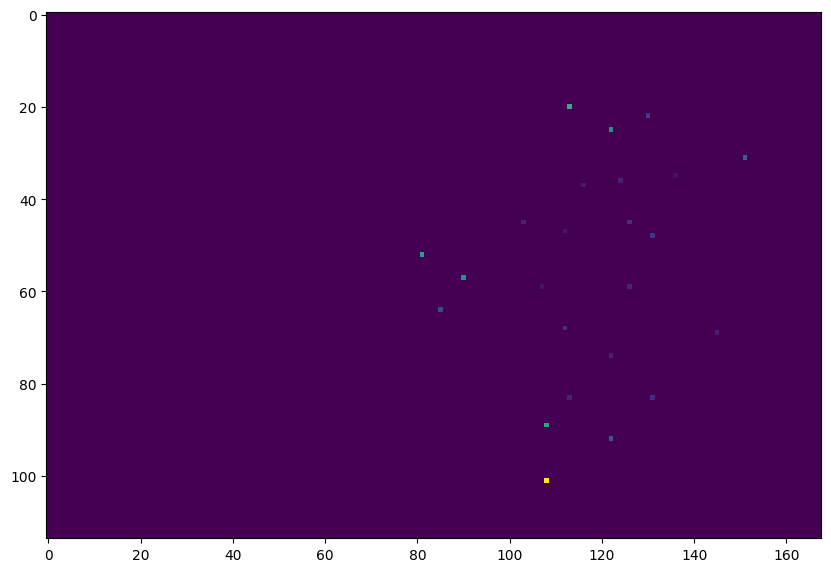

In [11]:
plt.figure(figsize = (10,10))
plt.imshow(x[0,:,:])

In [12]:
round(ds.dtm_roi_downsampled.rio.transform().e, 3)

-0.008

In [13]:
ds.dtm_roi_downsampled.rio.transform()

Affine(0.008353174603174602, 0.0, 6.62625,
       0.0, -0.008377192982456125, 45.26541666666667)

In [91]:
ds.dtm_roi_downsampled.rio.crs

CRS.from_epsg(4326)

In [92]:
ds.dtm_roi_downsampled

<xarray.DataArray '__xarray_dataarray_variable__' (band: 1, y: 114, x: 168)> Size: 77kB
array([[[2899.5454 , 2800.0447 , 2652.8933 , ...,  207.18225,
          203.91689,  200.8909 ],
        [2745.5928 , 2573.3943 , 2378.1335 , ...,  201.14403,
          197.62209,  194.39249],
        [2582.547  , 2200.7563 , 2236.475  , ...,  196.59752,
          194.13895,  190.74823],
        ...,
        [1816.2076 , 2051.5916 , 2158.6135 , ...,  829.5154 ,
          808.9886 ,  741.43695],
        [1769.3004 , 1817.0792 , 1762.4233 , ...,  840.6071 ,
          823.92474,  812.00555],
        [1609.5911 , 1636.23   , 1672.0851 , ...,  833.7745 ,
          827.46497,  753.8922 ]]], dtype=float32)
Coordinates:
  * x            (x) float64 1kB 6.63 6.639 6.647 6.655 ... 8.009 8.017 8.025
  * y            (y) float64 912B 45.26 45.25 45.24 45.24 ... 44.33 44.32 44.31
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    NETCDF_DIM_EXTRA:  {band}
    AREA_OR_POINT:     Area
    scale_factor:      1.0
    add_offset:        0.0
    NETCDF_DIM_band:   1
    _FillValue:        nan

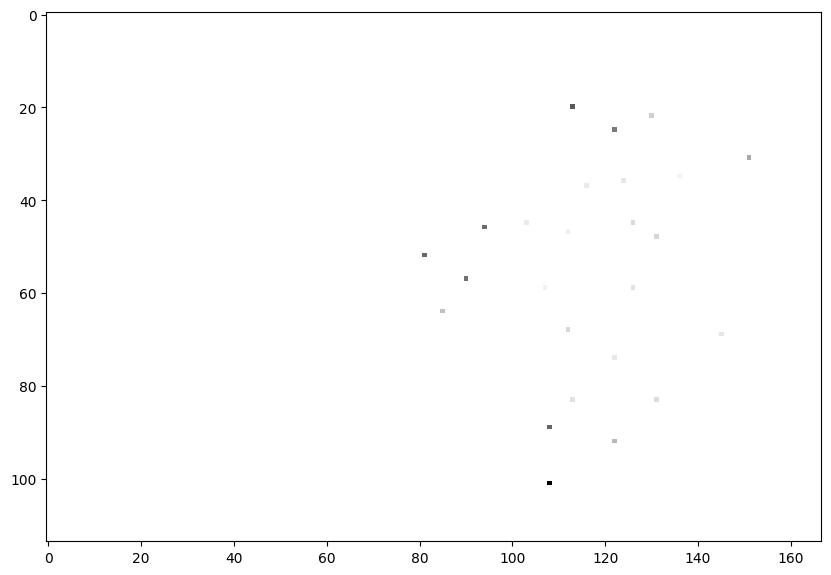

In [50]:
plt.figure(figsize = (10,10))
plt.imshow(ds.wtd_data_raserized["wtd"][-1].values, cmap="binary")

In [14]:
ds.dtm_roi_downsampled[0].shape

(114, 168)

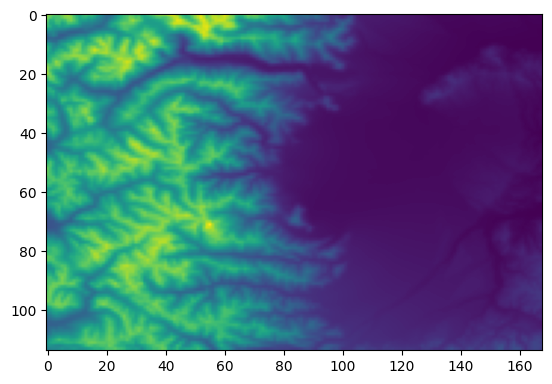

In [51]:
plt.imshow(ds.dtm_roi_downsampled[-1].values)

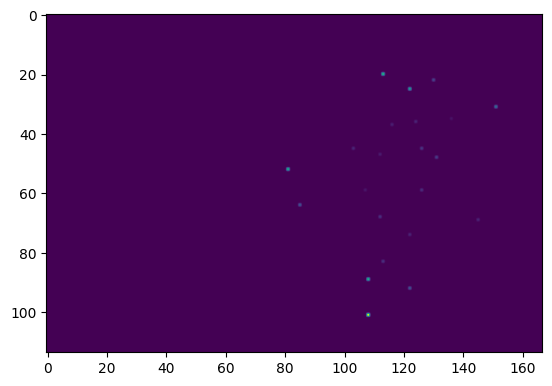

In [16]:
plt.imshow(ds.wtd_data_raserized["wtd"][-90])

In [ ]:
input_mask_p = 0.1
output_mask_p = 0.1

nonzero_idxs = np.nonzero(x[:,:,1])
input_mask_m = np.random.uniform(0,1,len(nonzero_idxs)) > input_mask_p
x[nonzero_idxs[:,0],nonzero_idxs[:,1],0] * input_mask_m

/scratch_local/ipykernel_3780105/1532092383.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x[nonzero_idxs[:,0],nonzero_idxs[:,1],0] * input_mask_m


tensor([-1.0026, -1.0026, -1.0026, -1.0026, -1.0026, -1.0026, -0.0000, -0.0000,
        -1.0026, -1.0026, -1.0026, -1.0026, -1.0026, -1.0026, -1.0026, -1.0026,
        -1.0026, -1.0026, -1.0026, -1.0026, -1.0026, -1.0026, -1.0026, -1.0026,
        -1.0026, -0.0000, -1.0026, -1.0026, -1.0026, -1.0026, -1.0026, -1.0026,
        -0.0000, -1.0026, -0.0000, -1.0026, -1.0026, -1.0026, -1.0026, -1.0026,
        -1.0026, -1.0026, -1.0026, -1.0026, -1.0026, -1.0026, -1.0026, -1.0026,
        -1.0026, -1.0026, -1.0026, -1.0026, -1.0026, -1.0026, -1.0026, -1.0026,
        -1.0026, -1.0026, -1.0026, -1.0026, -1.0026, -1.0026, -1.0026, -1.0026,
        -1.0026, -1.0026, -1.0026, -1.0026, -1.0026, -1.0026, -1.0026, -1.0026,
        -1.0026, -1.0026, -0.0000, -1.0026, -1.0026, -1.0026, -1.0026, -1.0026,
        -1.0026, -1.0026, -1.0026, -1.0026, -1.0026, -1.0026, -1.0026, -1.0026,
        -1.0026, -1.0026, -0.0000, -1.0026, -1.0026, -1.0026, -1.0026, -0.0000,
        -1.0026, -1.0026, -0.0000, -1.00

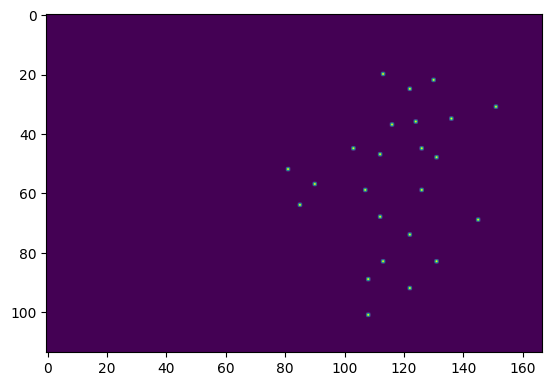

In [18]:
plt.imshow(x[1,:,:])

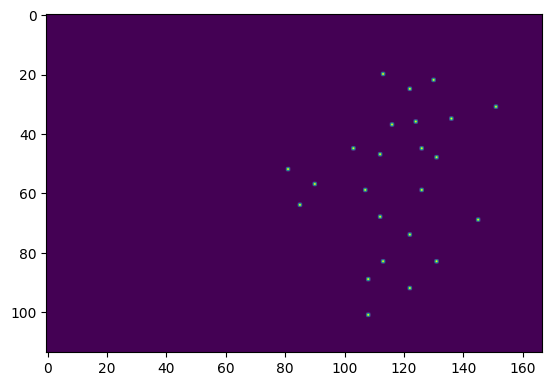

In [19]:
plt.imshow(z[-1,0,:,:])

In [20]:
ds.wtd_data_raserized["wtd"].shape

(8400, 114, 167)

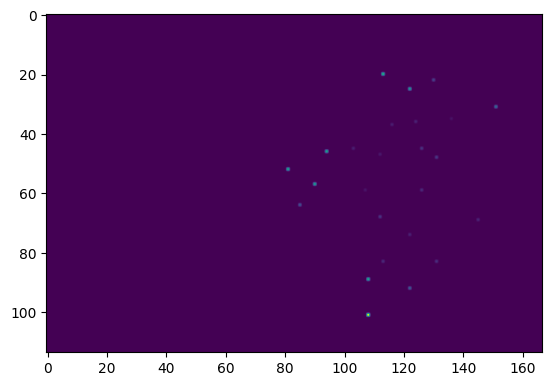

In [21]:
plt.imshow(ds.wtd_data_raserized["wtd"][-1,:,:])

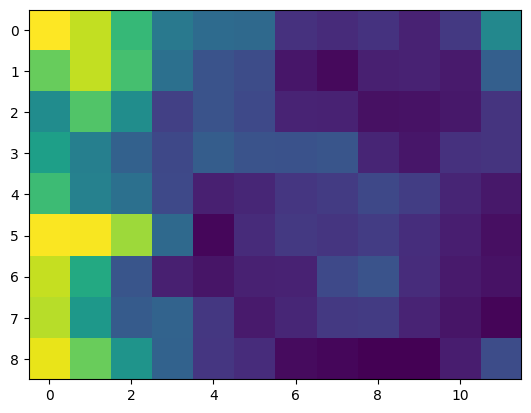

In [22]:
plt.imshow(ds.weather_xr["prec"][-1])

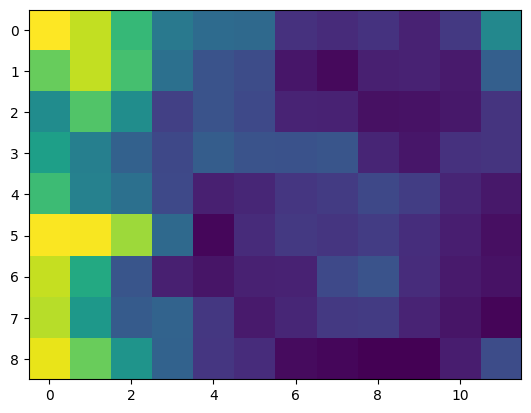

In [23]:
plt.imshow(y[0,-1,:,:])

# TEST DATALOADER

In [24]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [25]:
model = Discrete2DMidConcatNN(timesteps).to(device)

print("Total number of trainable parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

Total number of trainable parameters:  7149


In [26]:
batch_size = dict_files["batch_size"]
max_epochs = dict_files["epochs"]

test_split_p = dict_files["test_split_p"]
train_split_p = 1 - test_split_p

max_ds_elems = ds.__len__()
if not dict_files["all_dataset"]:
    max_ds_elems = dict_files["max_ds_elems"]

train_idx = int(max_ds_elems*train_split_p)
test_idx = int(max_ds_elems*test_split_p)

print(f"Traing size: {train_idx}, Test size: {test_idx}")

train_idxs, test_idxs = np.arange(train_idx), np.arange(train_idx, train_idx + test_idx)

train_sampler = SequentialSampler(train_idxs)
test_sampler = SequentialSampler(test_idxs)

train_loader = torch.utils.data.DataLoader(dataset=ds,
                                            batch_size=2,
                                            sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(dataset=ds,
                                            batch_size=2,
                                            sampler=test_sampler)

Traing size: 1600, Test size: 400


In [27]:
###### BETA ######

input_mask_p = 0.2
output_mask_p = 0.1

def apply_mask(x):
    # TODO: changed dimensions
    nonzero_idxs = np.nonzero(x[:,:,:,1])
    input_mask_m = np.random.uniform(0,1,len(nonzero_idxs)) > input_mask_p
    x[nonzero_idxs[:,0],nonzero_idxs[:,1],nonzero_idxs[:,2],0] = x[nonzero_idxs[:,0],nonzero_idxs[:,1],nonzero_idxs[:,2],0] * input_mask_m
    x[nonzero_idxs[:,0],nonzero_idxs[:,1],nonzero_idxs[:,2],1] = x[nonzero_idxs[:,0],nonzero_idxs[:,1],nonzero_idxs[:,2],1] * input_mask_m

###### BETA ######

In [28]:
###### BETA ######

def loss_masked_v1(y_hat,y):
    print(y_hat.shape)
    print(y.shape)
    # predict = y[:,0,:,:,:].to(device)
    predict = torch.unsqueeze(y[:,0,:,:,:], dim=1).to(device)
    target = y_hat.to(device)
    mask = y[:,1,:,:,:].bool().to(device)
    print(predict.shape)
    print(target.shape)
    print(torch.sum(mask))
    out = torch.sum((torch.masked_select(predict, mask) - torch.masked_select(target, mask))**2.0)  / torch.sum(mask)
    return out

###### BETA ######

In [29]:
def loss_masked(y_hat,y):
    print(y_hat.shape)
    print(y.shape)
    predict = torch.unsqueeze(y[:,0,:,:,:], dim=1).to(device)
    target = y_hat.to(device)
    mask = y[:,1,:,:,:].bool().to(device)

    out = (torch.sum( (predict - target) * mask) ** 2.0 ) / torch.sum(mask)
    return out

In [30]:
def ConvLon(x):
    conv = torch.Tensor([[-1,2,-1],[-1,2,-1],[-1,2,-1]] )
    out = torch.Tensor(x.shape)

    for b in range(x.shape[0]):
        for t in range(x.shape[2]):
            out[b,0,t,:,:] = torch.from_numpy(signal.convolve2d(x[b,0,t,:,:], conv, mode='same'))
    return out

def ConvLat(x):
    conv = torch.Tensor([[-1,-1,-1],[2,2,2],[-1,-1,-1]] )
    out = torch.Tensor(x.shape)

    for b in range(x.shape[0]):
        for t in range(x.shape[2]):
            out[b,0,t,:,:] = torch.from_numpy(signal.convolve2d(x[b,0,t,:,:], conv, mode='same'))

    # out = signal.convolve2d(x, conv, mode='same')
    return out

def pde_grad_loss(y_hat,dtm,wtd_mean,wtd_std):
    # TODO: normalized or de-normalized?
    print(y_hat.shape)

    predict = (y_hat * wtd_std) + wtd_mean # denormalized
    predict[:,0,:,:,:] = - predict[:,0,:,:,:] + dtm[0,:,:]
    predict.to(device)

    lat_grad = ConvLat(predict)
    lon_grad = ConvLon(predict)

    # y_hat_t_1 - y_hat_t = lat_grad_t + lon_grad_t
    loss = torch.sum(predict[:,0,1:-1,:,:] - predict[:,0,0:-2,:,:] + lat_grad[0,0,0:-2,:,:] + lon_grad[0,0,0:-2,:,:] )

    return torch.abs(loss)

In [35]:
model_file_path = f"{dict_files['save_model_dir']}/"

torch.Size([1, 2, 180, 114, 167])


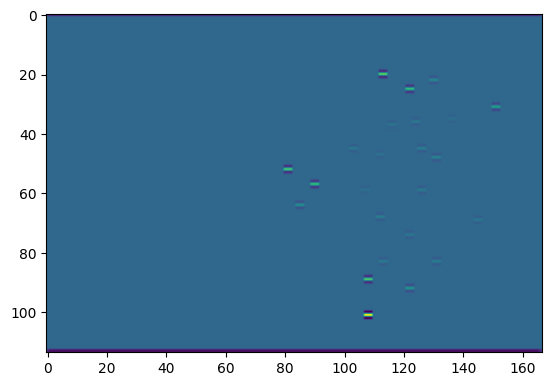

In [36]:
o = torch.unsqueeze(z, dim=0)
print(o.size())
o = ConvLat(o)
plt.imshow(o[0,0,0,:,:])

In [47]:
from tqdm import tqdm
import time

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

X = None
X_masked = None
Y = None

model.train()
start_time = time.time()

dtm = torch.from_numpy(ds.dtm_roi_downsampled.values)
wtd_mean = ds.wtd_numpy_mean
wtd_std = ds.wtd_numpy_std

for i in range(max_epochs):
    with tqdm(train_loader, unit="batch") as tepoch:
            for batch_idx, (init_wtd, weather, pred_wtds) in enumerate(tepoch):
                tepoch.set_description(f"Epoch {i}")

                X = (init_wtd.to(device), weather.to(device))
                Y = model(X)
                loss = pde_grad_loss(Y,
                                     dtm,
                                     wtd_mean,
                                     wtd_std)
                print(loss)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                
                
end_time = time.time()

Epoch 0:   0%|          | 0/800 [00:04<?, ?batch/s]

torch.Size([2, 1, 180, 114, 167])


RuntimeError: The size of tensor a (167) must match the size of tensor b (168) at non-singleton dimension 3

In [32]:
x1,y1,z1 = ds[0]
print(f"Sizes: {x1.shape} - {y1.shape} - {z1.shape}")

Sizes: torch.Size([2, 114, 167]) - torch.Size([10, 180, 9, 12]) - torch.Size([2, 180, 114, 167])


In [ ]:
model = Discrete2DMidConcatNN()
model.load_state_dict(torch.load("/leonardo_scratch/fast/IscrC_DL4EO/results/discrete_2d/models/model_20241230_145322.pt", weights_only=True, map_location=torch.device('cpu')))
model.eval()

Discrete2DMidConcatNN(
  (m_conv_1): ConvBlock(
    (block): Sequential(
      (0): Conv3d(2, 2, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=same)
      (1): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv3d(2, 2, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=same)
      (4): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv3d(2, 2, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=same)
      (7): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    )
  )
  (m_avg_pool_2): AdaptiveMaxPool3d(output_size=(None, 72, 96))
  (m_conv_tr_1): ConvTBlock(
    (block): Sequential(
      (0): ConvTranspose3d(10, 10, kernel_size=(1, 3, 3), stride=(1, 3, 3))
      (1): BatchNorm3d(10, eps=1e-05, momentum=0.1, affine=T

In [51]:
X = (torch.unsqueeze(x1, dim=0).to(device), torch.unsqueeze(y1, dim=0).to(device))
Y = model(X)
print(Y)
print(Y.shape)

tensor([[[[[0.0262, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0789],
           [0.0801, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0017],
           [0.0629, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0810, 0.0150, 0.0000,  ..., 0.0387, 0.0000, 0.0335],
           [0.0759, 0.0166, 0.0004,  ..., 0.0033, 0.0000, 0.0000],
           [0.0639, 0.0167, 0.0125,  ..., 0.0000, 0.0174, 0.0166]],

          [[0.0202, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0826],
           [0.0778, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0064],
           [0.0566, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0596, 0.0060, 0.0000,  ..., 0.0053, 0.0009, 0.0332],
           [0.0438, 0.0000, 0.0000,  ..., 0.0037, 0.0000, 0.0000],
           [0.0378, 0.0053, 0.0000,  ..., 0.0000, 0.0127, 0.0173]],

          [[0.0190, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0795],
           [0.0778, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0033],
           [0.0561, 0.0000

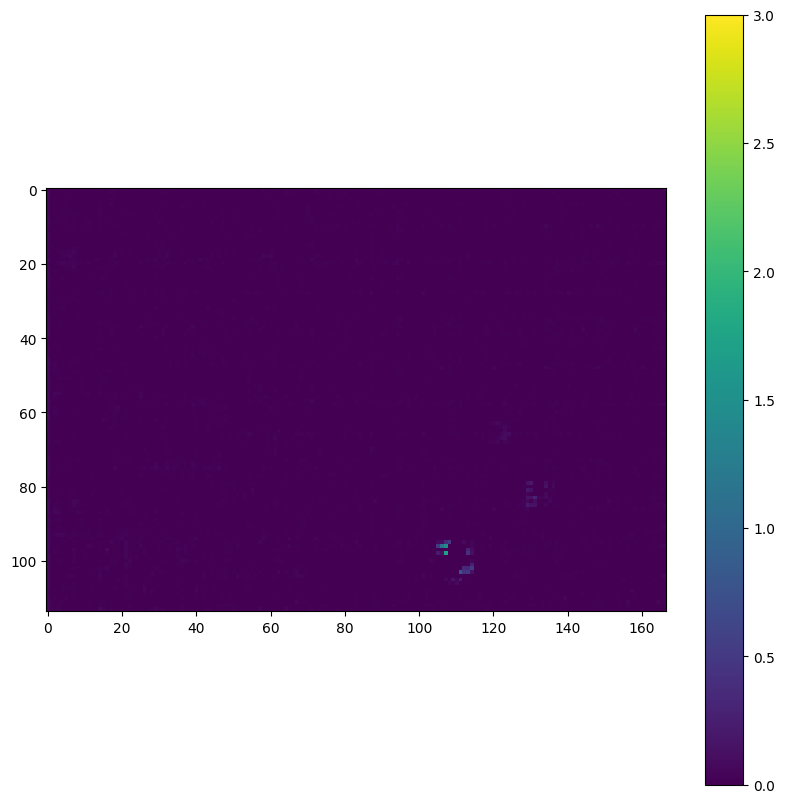

In [ ]:
with torch.no_grad():
    plt.figure(figsize = (10,10))
    plt.imshow(Y[0,0,0,:,:], vmax=3)
    plt.colorbar()

In [ ]:
z1[0,0,:,:].max()
ds.wtd_numpy_std

np.float32(0.43696696)

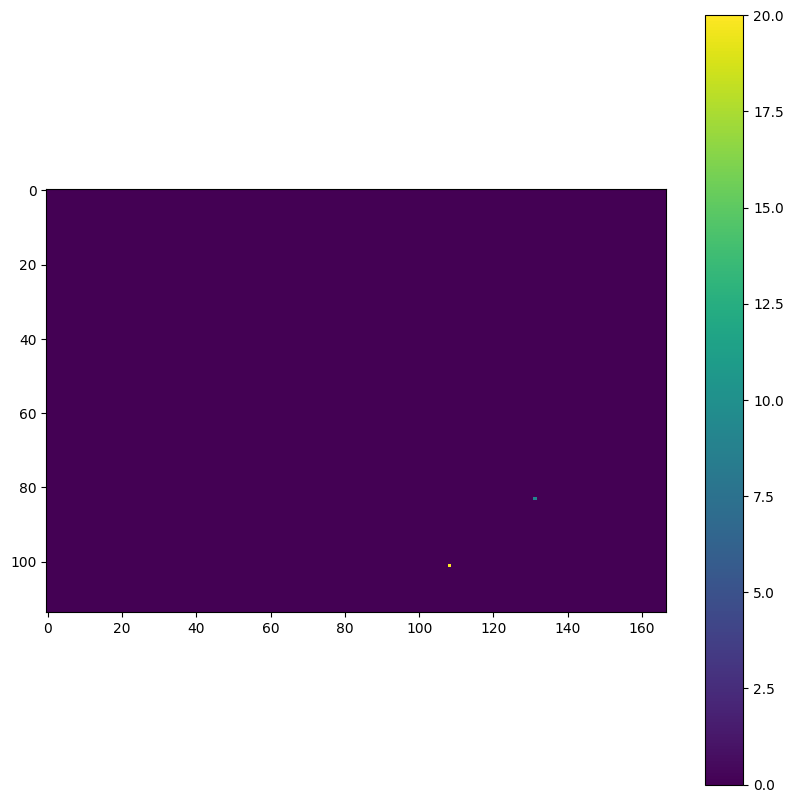

In [54]:
plt.figure(figsize = (10,10))
plt.imshow(z1[0,0,:,:],  vmax=20)
plt.colorbar()

In [100]:
x1,y1,z1 = ds[0]
print(f"Sizes: {x1.shape} - {y1.shape} - {z1.shape}")

Sizes: torch.Size([2, 114, 167]) - torch.Size([10, 180, 9, 12]) - torch.Size([2, 180, 114, 167])


In [101]:
z1[0,0,:,:].shape

torch.Size([114, 167])